In [1]:
import torch
from torch import nn

import model_predict

In [2]:
series, scaler = model_predict.read_data_series(scale=True, file_index=2)

时间序列不连贯，缺失的月份： ['2013-11', '2014-12', '2015-04', '2017-12']
即将填充缺失的月份
月份平均：
月份
1     165.417333
2     107.969333
3      95.301778
4     123.181000
5     154.631111
6     202.507111
7     136.807500
8     117.749000
9     157.433000
10    156.723500
11    156.563429
12    136.816000
Name: 销量（箱）, dtype: float64


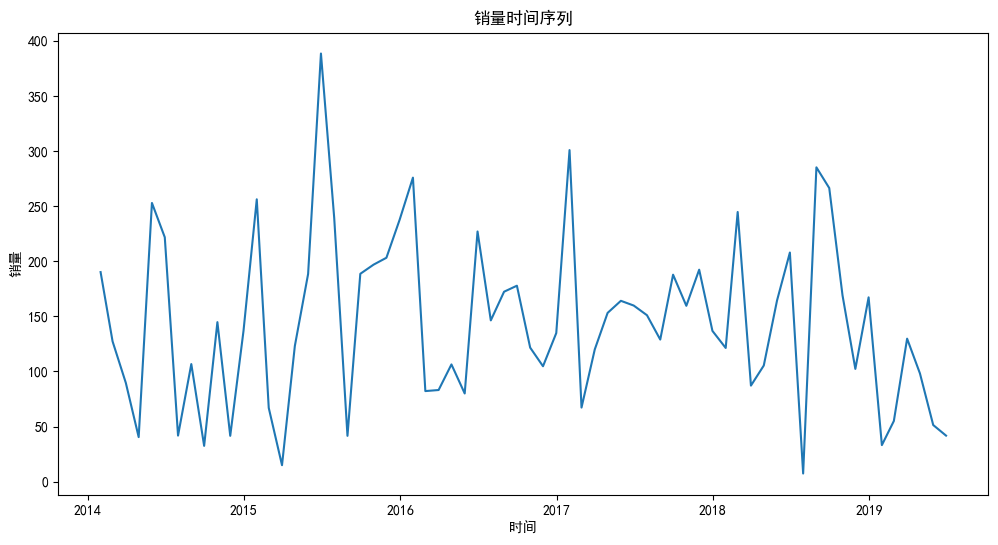

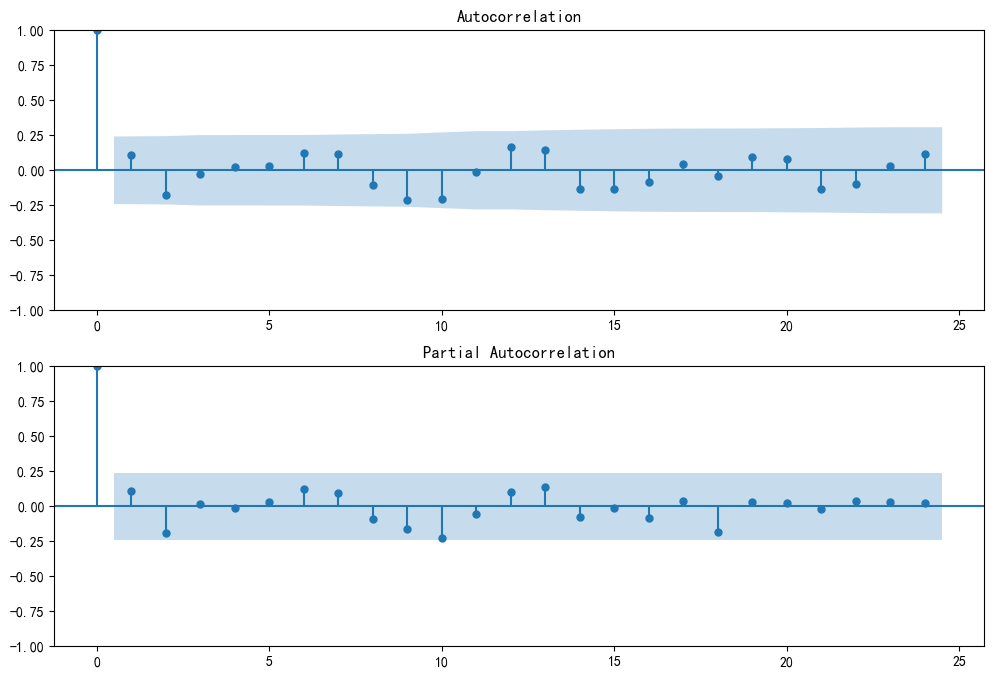

In [3]:
model_predict.plot_series_info(series, scaler)

In [4]:
# 4.1 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out

    def init_weights(self):
        # 遍历 LSTM 层的参数，对参数进行初始化
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.1)  # 使用正态分布初始化权重
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # 将偏置项初始化为零
                
model_parameters = {
    "input_size": 3, "hidden_size": 32, "num_layers": 1, "output_size": 1
}

In [5]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(LSTMModel, model_parameters, series, epochs=500)

训练 LSTMModel 模型
结果保存到： LSTMModel_best.pth
Epoch [50/500], Learn Rate: 1.0000e-03, Training Loss: 0.0323, Validation Loss: 0.0678
Epoch [100/500], Learn Rate: 1.0000e-03, Training Loss: 0.0232, Validation Loss: 0.0660
Epoch [150/500], Learn Rate: 1.0000e-03, Training Loss: 0.0168, Validation Loss: 0.0680
Epoch [200/500], Learn Rate: 1.0000e-03, Training Loss: 0.0097, Validation Loss: 0.0903
Epoch [250/500], Learn Rate: 5.0000e-04, Training Loss: 0.0063, Validation Loss: 0.1209
Epoch [300/500], Learn Rate: 5.0000e-04, Training Loss: 0.0050, Validation Loss: 0.1660
Epoch [350/500], Learn Rate: 5.0000e-04, Training Loss: 0.0039, Validation Loss: 0.2056
Epoch [400/500], Learn Rate: 5.0000e-04, Training Loss: 0.0030, Validation Loss: 0.2197
Epoch [450/500], Learn Rate: 5.0000e-04, Training Loss: 0.0023, Validation Loss: 0.2096
Epoch [500/500], Learn Rate: 2.5000e-04, Training Loss: 0.0020, Validation Loss: 0.2131
Best Validation Loss: 0.06601999700069427


从2018年6月开始后续数据推理
MSE: 10971.40
MAE: 90.79
R^2: -0.47
MAPE: 2.98


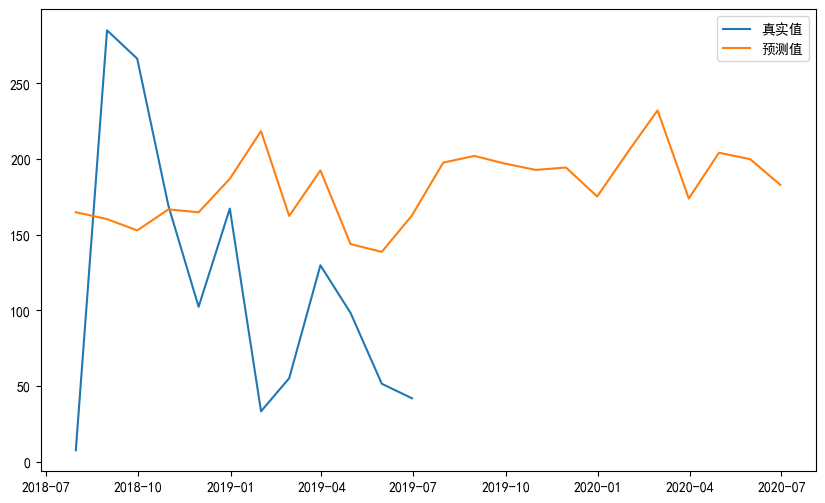

array([164.87180689, 160.32482621, 152.83444937, 166.72742497,
       164.82508776, 186.97838056, 218.53510499, 162.39559071,
       192.51565925, 143.77702316, 138.65574343, 162.74116469,
       197.65267476, 202.09081065, 197.08078263, 192.84475949,
       194.41619127, 175.25975765, 205.16650766, 232.20704175,
       173.91304319, 204.19347813, 199.9485426 , 182.96045573])

In [6]:
model = model_predict.load_rnn_model_best(LSTMModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler)